# CS-GY 9223-E: Deep Learning Homework 1
Due on Sunday, 11th February 2018, 11:55 PM

This homework can be done in pairs. Everyone must submit on NYU Classes individually.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Name, NetID

Member 2: Name, NetID

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [2]:
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        np.random.seed(1)
        
        self.parameters = {}
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda = []
        
        # init parameters
        for i in range(self.num_layers - 1):
            d_in  = layer_dimensions[i]
            d_out = layer_dimensions[i+1]
            self.parameters["w"+str(i)] = np.random.randn(d_in, d_out) * 1   /np.sqrt((d_in+d_out))
            self.parameters["b"+str(i)] = np.zeros(d_out)
        

    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        lin = np.matmul(A.T, W)
        print("\t", str(A.shape)+".T", "•", W.shape, "=", lin.shape)
        
        aff = lin + b
        print("\t(", lin.shape, "+", b.shape, ").T =", aff.T.shape)

        return aff.T
    

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return getattr(self,activation)(A)


    def relu(self, X):
        return np.maximum(X, 0)
    
    def tanh(self, X):
        return (np.exp(X)-np.exp(-X)) / (np.exp(X)+np.exp(-X))
    
    def dropout(self, A, prob):
        """
        :param A: Activation
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        
        return A, M

    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        
        cache = []
        A = X #A0 is the input
        for i in range(self.num_layers-1):
            print("compute:", i)
            W = self.parameters["w"+str(i)]
            b = self.parameters["b"+str(i)]
            Z = self.affineForward(A, W, b)
            A = self.activationForward(Z, 'relu')
            cache.append(A)
            
        AL = A # maybe this should be softmax(A)?
        
        return AL, cache
    
    def costFunction(self, AL, y):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param alpha: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        # compute loss
#         print("y.sh, AL.sh", y.shape, AL.shape)
#         print(AL)

        Y = np.zeros_like(AL)
#         print("YYY:", Y.shape, y.shape, len(y))
        Y[y, np.arange(len(y))] = 1
#         print(Y)
        
        y_pred = np.exp(AL) / np.sum(np.exp(AL), axis=0)

        cost = np.sum(Y * -np.log(y_pred)) / len(y)
#         cost = np.dot(AL, y)
                                   # if AL is un-softmaxed we can interpret AL as 
                                   # -log(P(y | x))

#         p = np.exp(AL)/np.sum(np.exp(AL))
#         cost = np.sum(-y * np.log(p))
        
#         if self.reg_lambda > 0:
#             # add regularization
#             cost += self.reg_lambda * np.sum(paramiters ** 2)
            
        # gradient of cost
        dAL = 0
        return cost, dAL

    def affineBackward(self, dA_prev, cache):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """

        return dA, dW, db

    def activationBackward(self, dA, cache, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        pass

        
    def relu_derivative(self, dx, cached_x):

        return dx

    def dropout_backward(self, dA, cache):

        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {}
        
#         for i in range(0): # fill in
            
            
#             if self.drop_prob > 0:
                #call dropout_backward
           
            
#         if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
        
        return gradients


    def updateParameters(self, gradients, alpha):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        """

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
#         for i in range(0, iters):
            # get minibatch
            
            # forward prop

            # compute loss

            # compute gradients

            # update weights and biases based on gradient

#             if i % print_every == 0:
                # print cost, train and validation set accuracies
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        AL, cache = NN.forwardPropagation(X)
        
        y_pred = np.exp(AL) / np.sum(np.exp(AL), axis=0)
        
        return y_pred

    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """

        return X_batch, y_batch

In [3]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    One-hot encoding converts categorical labels to binary values
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [4]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [5]:
# Load the data
data_root_path = 'cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


### run some tests

In [6]:
layer_dimensions = [X_train.shape[0], 100, 500, 100, 30, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=10, alpha=0, batch_size=128, print_every=10)

# print([k for k in NN.parameters.keys()])
# print([v.shape for v in NN.parameters.values()])

print("weight and bias dimentions and norms")
print([[k, v.shape] for k,v in NN.parameters.items()])
print([np.sum(v ** 2) for k,v in NN.parameters.items()])
print()

print("test affineForward")
A = np.array([[1, 0], [0, 1]])
W = np.array([[4, 1], 
     [2, 2]])
print(NN.affineForward(A, W, np.array([0,0]).T))
A = np.array([1,1])
print(A.shape)
print(NN.affineForward(A, W, np.array([0,0])))

print("\ntest activation")
z = [.1, .2, -.2, 1, -1, -1, -1, 1, 1, 1, 2]
print(z)
print(NN.relu(z))
print(NN.activationForward(z))

print("\n")

# print(X_train.shape)
# print(X_train[:, 0].shape)
# print(X_train[1].shape)


print("\ntest forward prop")
AL, cache = NN.forwardPropagation(X_train[:, :10000])
print("\nAL:", AL.shape)

print("\n\n")

print("test cost")
cost, dAL = NN.costFunction(AL, y_train[:10000])
print("cost: (", cost, "?=", 2.3, ")  (", np.exp(-cost), "?=", 0.1,")") # cost \approx    2.3  \approx    -log(1/10)     => :-)
print("\t/\ should be about 2.3 and .1\n\n")

y_hat = NN.predict(X_train[:, :10000])

print("\n\ntest predict\n")
print("predict: \n", y_hat.shape)

print("\nacc: ", np.mean(np.argmax(y_hat, axis=0) == y_train[:10000]))
print("\t/\ should be about .1")

print("\n\n\n", np.row_stack( (y_hat[:, :5], np.sum( y_hat[:, :5], axis=0)) ) )  # last row = 1  => :-)
print("\t/\ should all add to 1")


weight and bias dimentions and norms
[['w0', (3072, 100)], ['b0', (100,)], ['w1', (100, 500)], ['b1', (500,)], ['w2', (500, 100)], ['b2', (100,)], ['w3', (100, 30)], ['b3', (30,)], ['w4', (30, 10)], ['b4', (10,)]]
[96.705409068191841, 0.0, 83.713041722260499, 0.0, 83.518267687707208, 0.0, 23.380817608845941, 0.0, 8.2896928371807324, 0.0]

test affineForward
	 (2, 2).T • (2, 2) = (2, 2)
	( (2, 2) + (2,) ).T = (2, 2)
[[4 2]
 [1 2]]
(2,)
	 (2,).T • (2, 2) = (2,)
	( (2,) + (2,) ).T = (2,)
[6 3]

test activation
[0.1, 0.2, -0.2, 1, -1, -1, -1, 1, 1, 1, 2]
[ 0.1  0.2  0.   1.   0.   0.   0.   1.   1.   1.   2. ]
[ 0.1  0.2  0.   1.   0.   0.   0.   1.   1.   1.   2. ]



test forward prop
compute: 0
	 (3072, 10000).T • (3072, 100) = (10000, 100)
	( (10000, 100) + (100,) ).T = (100, 10000)
compute: 1
	 (100, 10000).T • (100, 500) = (10000, 500)
	( (10000, 500) + (500,) ).T = (500, 10000)
compute: 2
	 (500, 10000).T • (500, 100) = (10000, 100)
	( (10000, 100) + (100,) ).T = (100, 10000)
comput

#### check the distribution on the outputs

(10000,)
y_ [ 0.09944389  0.09919019  0.09919019  0.10052757  0.09919019  0.10194145
  0.09919019  0.09919019  0.10294595  0.09919019]
8
0.102945950317
p: 8
mean: [ 0.09949408  0.0990312   0.09915254  0.1014228   0.09903188  0.10234821
  0.0990319   0.09929486  0.10215683  0.09903569]


array([  994.94083011,   990.31203158,   991.52536679,  1014.22804202,
         990.31875412,  1023.48208389,   990.31904887,   992.9486419 ,
        1021.56825118,   990.35694954])

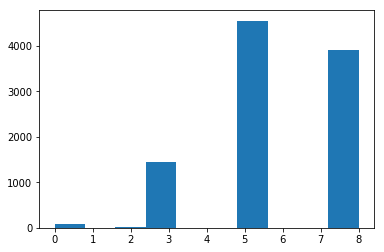

In [7]:
y_hat.shape
p = np.argmax(y_hat, axis = 0)
print(p.shape)
print("y_", y_hat[:, 1000])

print(np.argmax(y_hat[:, 1000]))
print(np.max(y_hat[:, 1000]))

print("p:", p[1000])
plt.hist(p)

print("mean:", np.mean(y_hat, axis=1))
np.sum(y_hat, axis=1)

## Split train into train and validation sets

In [ ]:
# X_train = ...
# y_train = ...

# X_val   
# y_val

## Part 1

#### Simple fully-connected deep neural network

In [ ]:
layer_dimensions = [X_train.shape[0], 1, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=10, alpha=0, batch_size=128, print_every=10)

In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
NN2 = NeuralNetwork(layer_dimensions, drop_prob=0, reg_lambda=0)
NN2.train(X_train, y_train, iters=1000, alpha=0.00001, batch_size=1000, print_every=10)

In [ ]:
y_predicted2 = NN2.predict(X)
save_predictions(y_predicted, 'ans2-uni')